In [16]:

import pandas as pd
import matplotlib.pyplot as plt
import bambi as bmb
import arviz as az
from sklearn.preprocessing import StandardScaler

Problemen:
- Geen volledige paden in repo (veiligheidsrisicio)
- Encoding dataset naar UTF8 omzetten (encoding problemen?)

In [17]:
df = pd.read_csv("../Materials/KVO_META.csv", encoding='utf8')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df.sample(5)

,Image,Collection,Production,Date,Occasion,Multiple bill,Performances_ID,Normalised title,Original language,Composer,World-premiere,Original title,Genre,Directors
237,K.V.O. programmas 1893-97_00502-20211201_13334...,1893-1897,Herbergprinses,1897-03-02,NaN,False,346598,Herbergprinses,NL,Jan Blockx,1896,Herbergprinses,zangspel,Edward Keurvels & Henry Fontaine
331,1897-1900 Nederlandsch Lyrisch Tooneel. Progra...,1897-1900,Cleopatra,1898-12-03,Gala-vertoning,False,378899,Cleopatra,DEE,August Enna,1894,Cleopatra,opera seria,Karel van Walle
1167,1907-1908 Vlaamsche opera_00181-20211216_14003...,1907-1908,De Wilddief,1908-04-07,Laatste vertoning,True,414962,De Wilddief,DUI,Albert Lortzing,1842,Der Wildschütz,zangspel,Jef Judels & Bernard Tokkie
1182,1908-1909 Vlaamsche opera_00033-20211216_14092...,1908-1909,Faust,1908-10-18,NaN,True,669427,Faust,FR,Charles Gounod,1859,Faust,grand opera,Jef Judels & Bernard Tokkie
973,Nederlandsch Lyrisch Tooneel 1906-1907_00074-2...,1906-1907,Laagland,1906-12-11,NaN,False,367717,Laagland,DUI,Albert D'Eugen,1903,Tiefland,melodramatische oper,Jef Judels & Bernard Tokkie


In [18]:
data = []

for work, group in df.groupby('Normalised title'):
    group = group.groupby('Collection').sample(1) # consider one performance per season?
    group = group.sort_values('Date').iloc[0:2] # get very first performace and first reperformance
    if len(group) > 1:
        time_diff = group.iloc[1]['Date'].year - group.iloc[0]['Date'].year
        meta = list(group.iloc[0][['Normalised title', 'Directors', 'Composer', 'Original language', 'Genre', 'Date']].values)
        data.append(meta + [time_diff])

data = pd.DataFrame(data, columns=['titel', 'directie', 'componist', 'taal', 'genre', 'datum', 'diff'])
data = data[~data['diff'].isna()]
data

,titel,directie,componist,taal,genre,datum,diff
0,Carmen,Fé Derickx & Bernard Tokkie,Georges Bizet,FR,opéra comique,1928-04-29,4.0
1,Christ'l,Henry Fontaine,Georg Jarno,?,leichte oper,1911-03-26,0.0
2,Czaar en Timmerman,Jef Judels & Bernard Tokkie,Albert Lortzing,DUI,zangspel,1904-03-26,4.0
3,Dansenreeks,Fé Derickx & Bernard Tokkie,?,?,Ballet,1924-01-22,1.0
4,Dansenreeks,Fé Derickx & Bernard Tokkie,?,?,Ballet,1924-04-05,5.0
...,...,...,...,...,...,...,...
143,Tristan en Isolde,Henry Fontaine,Richard Wagner,DUI,gesamtkunstwerk,1910-12-16,14.0
144,Weenerbloed,Fé Derickx & Bernard Tokkie,Johann Strauss,DUI,operette,1930-04-06,1.0
145,Winternachtsdroom,Jef Judels & Bernard Tokkie,August de Boeck,NL,lyrisch drama,1904-02-20,2.0
146,Winternachtsdroom,Jef Judels & Bernard Tokkie,August De Boeck,NL,Lyrisch Drama,1902-12-23,5.0


In [19]:
data.dtypes

titel                object
directie             object
componist            object
taal                 object
genre                object
datum        datetime64[ns]
diff                float64
dtype: object

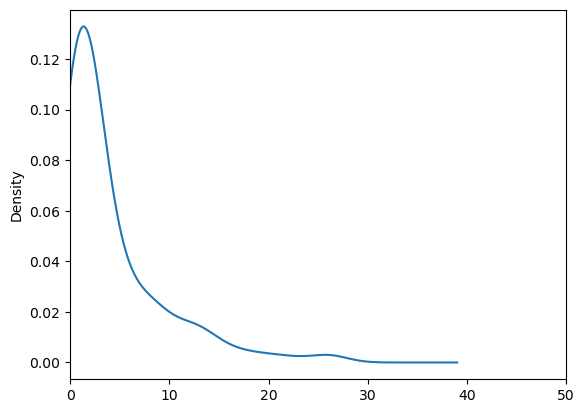

In [20]:
data['diff'].plot.kde()
plt.xlim((0, 50));

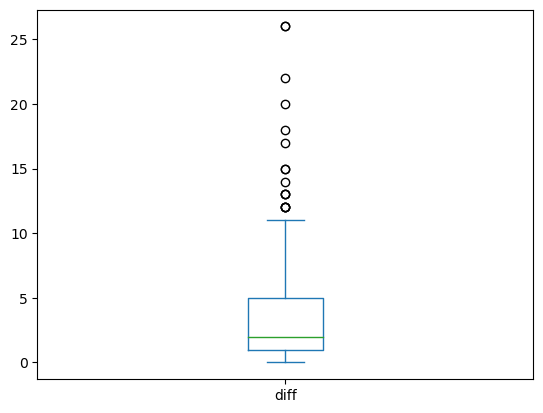

In [21]:
data['diff'].plot.box();

In [22]:
data['diff'].describe()

count    147.000000
mean       4.020408
std        5.186216
min        0.000000
25%        1.000000
50%        2.000000
75%        5.000000
max       26.000000
Name: diff, dtype: float64

In [23]:
import numpy as np
data['diff'] = data['diff'].astype(np.int32)

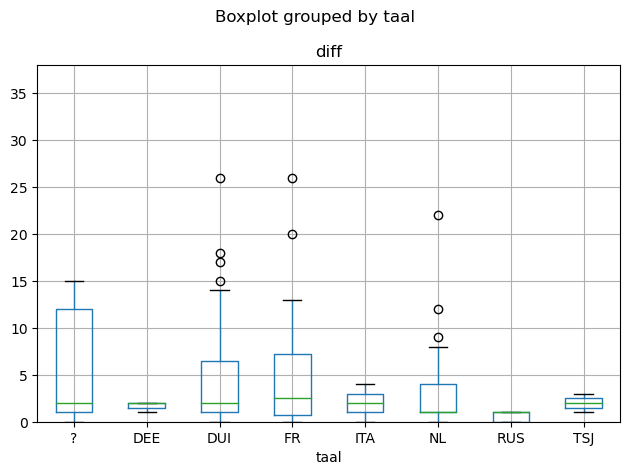

In [24]:
data.boxplot('diff', 'taal')
plt.ylim(0, 38)
plt.tight_layout();

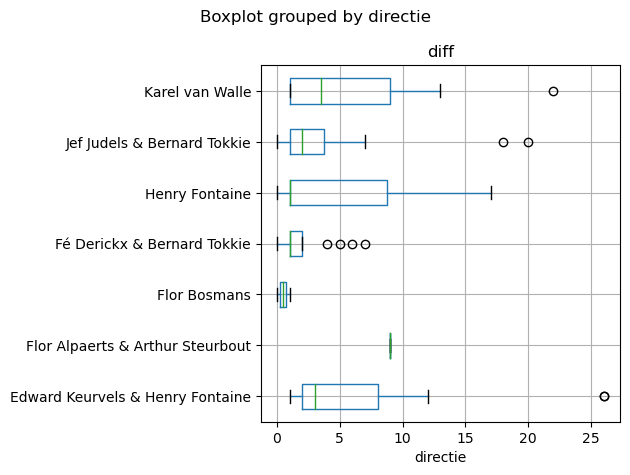

In [25]:
data.boxplot('diff', 'directie', vert=False)
plt.tight_layout();

In [26]:
print(len(data))
data = data[~data.isna()]
print(len(data))

147
147


In [27]:
data = data[['taal', 'diff', 'directie']]
data['taal'].fillna('<UNK>', inplace=True)
data['taal'] = data['taal'].str.replace('?', '<UNK>', regex=False)
data.sample(10)

,taal,diff,directie
48,DUI,8,Edward Keurvels & Henry Fontaine
21,NL,0,Jef Judels & Bernard Tokkie
62,RUS,1,Fé Derickx & Bernard Tokkie
20,NL,1,Jef Judels & Bernard Tokkie
128,NL,12,Edward Keurvels & Henry Fontaine
54,NL,1,Jef Judels & Bernard Tokkie
74,<UNK>,1,Fé Derickx & Bernard Tokkie
136,DUI,2,Fé Derickx & Bernard Tokkie
68,DUI,9,Karel van Walle
111,FR,0,Fé Derickx & Bernard Tokkie


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, taal, directie]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 182 seconds.


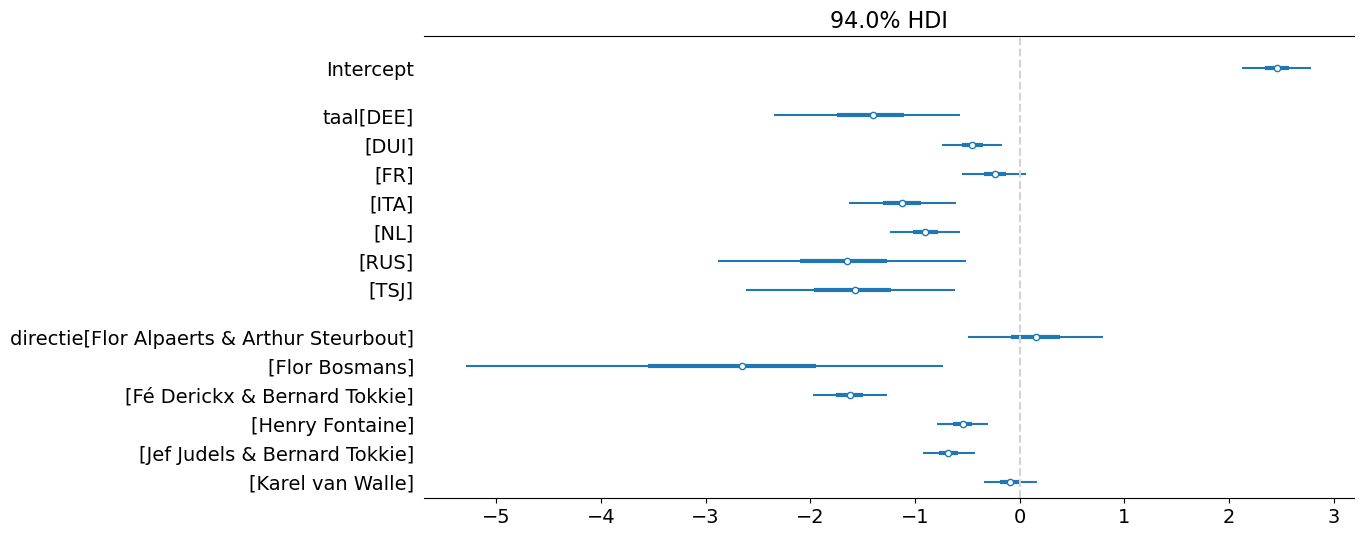

In [28]:
model = bmb.Model('diff ~ taal + directie', data, family='poisson')
fit = model.fit(draws=1000, chains=4)
az.summary(fit)
az.plot_forest(fit, combined=True, figsize=(12, 6))
plt.axvline(0, c='lightgrey', ls='--');